# Make time zone specification shapefile for WSC stations
## Description
WSC provides daily average flows calculated in Local Standard Time, but does not provide easily accessible information on what LST for each gauge is. We need to somehow map the gauges onto time zones to find the right time coordinates for storing the daily average flows into netcdf. 

Communication with WSC (2023-04-07) indicates that:
```
Q: According to this wikipedia page (https://en.wikipedia.org/wiki/Time_in_Canada) Local Standard Time seems to be a regional choice, and a single province/territory could have regions in it with different time zones. Could you tell me if these daily averages are calculated using a single LST choice per province/territory, or if these daily averages are based on the exact time zone the region the station is in uses? 

A: Our Field Techs use the official time zone for the area they are in.  We do not use municipal or any type of local or municipal exceptions. [..] Here is a link to the Government of Canada information page on time zones in Canada.  I would suggest you use that one as that is what we would follow.
```
https://nrc.canada.ca/en/certifications-evaluations-standards/canadas-official-time/time-zones-daylight-saving-time

Problems:
1. Official timezones do not map cleanly onto provincial/territorial boundaries, so we need a dedicated time-zone-shapefile to map station locations onto time zones. No such shapefile of Canada's official time zones is available, so we have to build our own;
2. Additionally, WSC maintains several gauges in cross-boundary watersheds so we need some info from those USA states too.

## List of states/provinces/territories 
We use station data from the following provinces/territories in Canada:
- Alberta
- British Columbia
- Manitoba
- New Brunswick
- Newfoundland and Labrador
- Nova Scotia
- Northwest Territories
- Nunavut
- Ontario
- Prince Edward Island
- Quebec
- Saskatchewan
- Yukon

We use station data from the following states in the USA:
- Alaska
- Idaho
- Maine
- Montana
- Washington

See file `./6_flow_data/3b_daily_csv_to_netcdf.ipynb` (bottom part).

## Data sources
- Image: Official time zone outlines used in Canada [1]
- Shapefile: Canada Census provincial and territorial boundaries [2,3]
- Shapefile: United States of America census state boundaries [4,5]
- Shapefile: Time zone definitions [6]

## Procedure
1. Manually (in QGIS):
    1. Open the three shapefiles
    2. Match the correct shapefiles to the image with official time zones
    3. Export selections as individual files for each combination of country and timezone
    4. Dissolve these selection files
2. Use this script to:
    1. Load the dissolved polygons
    2. Merge only the geometries (the dissolved files have many different columns we don't need here)
    3. Add country and time zone (tz) columns
    4. Save to file

## References
[1] Canada, N. R. C. (2019, March 23). Time zones and daylight saving time. https://nrc.canada.ca/en/certifications-evaluations-standards/canadas-official-time/time-zones-daylight-saving-time. Accessed 2023-04-07.

[2] Government of Canada, S. C. (2021, November 17). 2021 Census Boundary files. https://www12.statcan.gc.ca/census-recensement/2021/geo/sip-pis/boundary-limites/index2021-eng.cfm?year=21. Accessed 2023-04-07.

[3] Download link: https://www12.statcan.gc.ca/census-recensement/alternative_alternatif.cfm?l=eng&dispext=zip&teng=lpr_000a21a_e.zip&k=%20%20%20%20%202712&loc=//www12.statcan.gc.ca/census-recensement/2021/geo/sip-pis/boundary-limites/files-fichiers/lpr_000a21a_e.zip. Accessed 2023-04-07.

[4] US Census Bureau. (n.d.). TIGER/Line Shapefiles. Census.Gov. Retrieved July 4, 2023, from https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html. Accessed 2023-04-07.

[5] Download link: https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=States+%28and+equivalent%29. Accessed 2023-04-07.

[6] Siroky, E. (2023). Timezone Boundary Builder [JavaScript]. https://github.com/evansiroky/timezone-boundary-builder (Original work published 2016). Release 2023b. Accessed 2023-04-07.


## Processing

In [112]:
import pandas as pd
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt

In [110]:
# files
base = Path('C:/Globus endpoint/CAMELS_spat/reference_shapes/Boundaries/merged')
main = base / 'dissolved'
can_ast = main / 'can_AST_diss.shp' # Atlantic Standard Time
can_cst = main / 'can_CST_diss.shp' # Central Standard Time
can_est = main / 'can_EST_diss.shp' # Eastern Standard Time
can_mst = main / 'can_MST_diss.shp' # Mountain Standard Time
can_nst = main / 'can_NST_diss.shp' # Newfoundland Standard Time
can_pst = main / 'can_PST_diss.shp' # Pacific Standard Time
usa_cst = main / 'usa_CST_diss.shp' 
usa_est = main / 'usa_EST_diss.shp' 
usa_lst = main / 'usa_LST_diss.shp' #'Laska Standard Time (note: not a formal abbreviaton)
usa_mst = main / 'usa_MST_diss.shp'
usa_pst = main / 'usa_PST_diss.shp'

In [81]:
shp_list = [gpd.read_file(can_ast),
            gpd.read_file(can_cst),
            gpd.read_file(can_est),
            gpd.read_file(can_mst),
            gpd.read_file(can_nst),
            gpd.read_file(can_pst),
            gpd.read_file(usa_cst),
            gpd.read_file(usa_est),
            gpd.read_file(usa_lst),
            gpd.read_file(usa_mst),
            gpd.read_file(usa_pst)]

In [97]:
# Create new file
wsc_tz = gpd.GeoDataFrame(columns=['geometry'],crs='EPSG:4326')
lst_tz = []

In [98]:
for shp in shp_list:
    tmp = shp[['geometry']].copy()
    tmp = tmp.to_crs('EPSG:4326')
    wsc_tz = pd.concat([wsc_tz, tmp], ignore_index=True)

In [103]:
wsc_tz['country'] = ['can','can','can','can','can','can','usa','usa','usa','usa','usa']
wsc_tz['tz']      = ['AST','CST','EST','MST','NST','PST','CST','EST','LST','MST','PST']

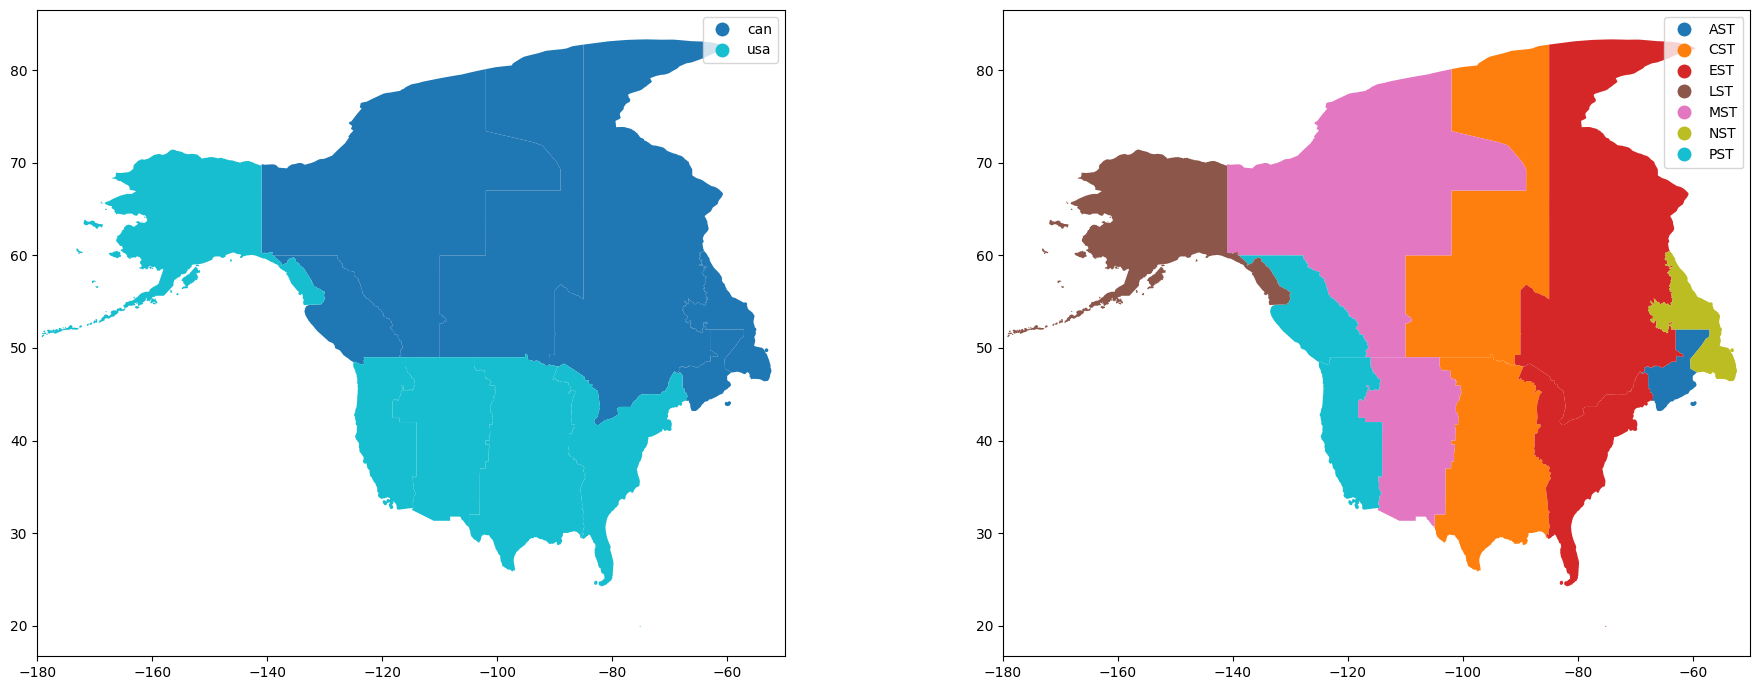

In [117]:
fig,axs = plt.subplots(1,2,figsize=(20,7))

wsc_tz.plot(column='country', legend=True, ax=axs[0])
axs[0].set_xlim([-180,-50])

wsc_tz.plot(column='tz', legend=True, ax=axs[1])
axs[1].set_xlim([-180,-50])

plt.tight_layout()

In [111]:
wsc_tz.to_file(base/'can_usa_timezones.shp')